# Example 4: From Naive Estimates to Rigorous Analysis

Using an MI estimator naively is rarely a good idea. While our `'estimate'` mode is fast, it doesn't account for two critical statistical pitfalls:
1.  **Estimator Variance:** Due to random seeds, running the same estimation twice will give slightly different answers.
2.  **Finite-Sampling Bias:** The MI estimate depends on the number of samples. With a finite dataset, estimators tend to find spurious correlations, overestimating the true MI. 

This notebook demonstrates these problems and shows how to get a single, robust, and principled MI estimate using `mode='rigorous'`.

## 1. Imports

In [6]:
import torch
import numpy as np
import pandas as pd
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

## 2. Generating Data

We'll use a complex, nonlinear dataset. We use a moderate number of samples (`n_samples=2500`) to ensure the task is challenging enough to show bias, but feasible for the rigorous analysis to succeed.

In [8]:
n_samples = 1500
latent_dim = 4
observed_dim = 100
latent_mi_bits = 3.0

x_raw, y_raw = nmi.datasets.generate_nonlinear_from_latent(
    n_samples=n_samples, latent_dim=latent_dim, 
    observed_dim=observed_dim, mi=latent_mi_bits
)

x_raw_transposed = x_raw.T
y_raw_transposed = y_raw.T

print(f"Transposed X data shape: {x_raw_transposed.shape}")

Transposed X data shape: torch.Size([100, 1500])


## 3. The Problem: Unreliable Naive Estimates

Let's show how naive estimates violate the principle that MI should be a stable property of the data distribution.

In [9]:
base_params = {
    'n_epochs': 100, 
    'learning_rate': 1e-3, 
    'batch_size': 128,
    'patience': 15,
    'embedding_dim': 20, 
    'hidden_dim': 128, 
    'n_layers': 3
}

# --- Problem 1: Estimator Variance ---
print("--- Demonstrating Estimator Variance ---")
results_1 = nmi.run(x_data=x_raw_transposed, y_data=y_raw_transposed, mode='estimate', processor_type='continuous', processor_params={'window_size': 1}, base_params=base_params, random_seed=42, verbose=False)
results_2 = nmi.run(x_data=x_raw_transposed, y_data=y_raw_transposed, mode='estimate', processor_type='continuous', processor_params={'window_size': 1}, base_params=base_params, random_seed=123, verbose=False)
print(f"Run 1 (seed=42):  {results_1.mi_estimate:.3f} bits")
print(f"Run 2 (seed=123): {results_2.mi_estimate:.3f} bits")

# --- Problem 2: Finite-Sampling Bias ---
print("\n--- Demonstrating Finite-Sampling Bias ---")
results_half_data = nmi.run(x_data=x_raw_transposed[:, :n_samples//2], y_data=y_raw_transposed[:, :n_samples//2], mode='estimate', processor_type='continuous', processor_params={'window_size': 1}, base_params=base_params, random_seed=42, verbose=False)
print(f"Estimate on ALL data:   {results_1.mi_estimate:.3f} bits")
print(f"Estimate on HALF data:  {results_half_data.mi_estimate:.3f} bits")

--- Demonstrating Estimator Variance ---
2025-10-04 19:04:18 - neural_mi - INFO - Starting parameter sweep with 12 workers...


Parameter Sweep Progress:   0%|          | 0/1 [00:00<?, ?task/s]

2025-10-04 19:04:23 - neural_mi - INFO - Parameter sweep finished.
2025-10-04 19:04:23 - neural_mi - INFO - Starting parameter sweep with 12 workers...


Parameter Sweep Progress:   0%|          | 0/1 [00:00<?, ?task/s]

2025-10-04 19:04:28 - neural_mi - INFO - Parameter sweep finished.
Run 1 (seed=42):  3.005 bits
Run 2 (seed=123): 2.677 bits

--- Demonstrating Finite-Sampling Bias ---
2025-10-04 19:04:28 - neural_mi - INFO - Starting parameter sweep with 12 workers...


Parameter Sweep Progress:   0%|          | 0/1 [00:00<?, ?task/s]

2025-10-04 19:04:32 - neural_mi - INFO - Parameter sweep finished.
Estimate on ALL data:   3.005 bits
Estimate on HALF data:  2.528 bits


Notice how the estimate changes with both the random seed and, more dramatically, with the number of samples. This is unacceptable for rigorous science.

## 4. The Solution: Rigorous, Bias-Corrected Estimation

The `'rigorous'` mode solves both problems by subsampling the data, extrapolating to infinite samples, and providing a confidence interval. We wrap the call in a `try...except` block to gracefully handle potential training failures on this difficult task.

In [10]:
rigorous_results = nmi.run(
    x_data=x_raw_transposed,
    y_data=y_raw_transposed,
    mode='rigorous',
    processor_type='continuous',
    processor_params={'window_size': 1},
    base_params=base_params,
    sweep_grid={'embedding_dim': [16]},
    n_workers=4,
    random_seed=42,
    verbose=False
)

print("\n--- Rigorous vs. Naive Estimates ---")
print(f"Naive Estimate (Run 1): {results_1.mi_estimate:.3f} bits")
    
mi_est = rigorous_results.mi_estimate
mi_err = rigorous_results.details.get('mi_error', 0.0)
    
print(f"\nCorrected MI:           {mi_est:.3f} ± {mi_err:.3f} bits")

2025-10-04 19:05:02 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-04 19:05:02 - neural_mi - INFO - Starting rigorous analysis with 4 workers...


Rigorous Analysis Progress:   0%|          | 0/55 [00:00<?, ?task/s]

2025-10-04 19:05:15 - neural_mi - INFO - All training tasks finished. Performing bias correction...

--- Rigorous vs. Naive Estimates ---
Naive Estimate (Run 1): 3.005 bits

Corrected MI:           3.064 ± 0.203 bits


## 5. Visualizing the Correction

The plot shows the raw, biased MI estimates at different data fractions (gray dots), and the red dashed line shows the extrapolation to `1/N = 0` (infinite data), which gives us our final, corrected estimate.

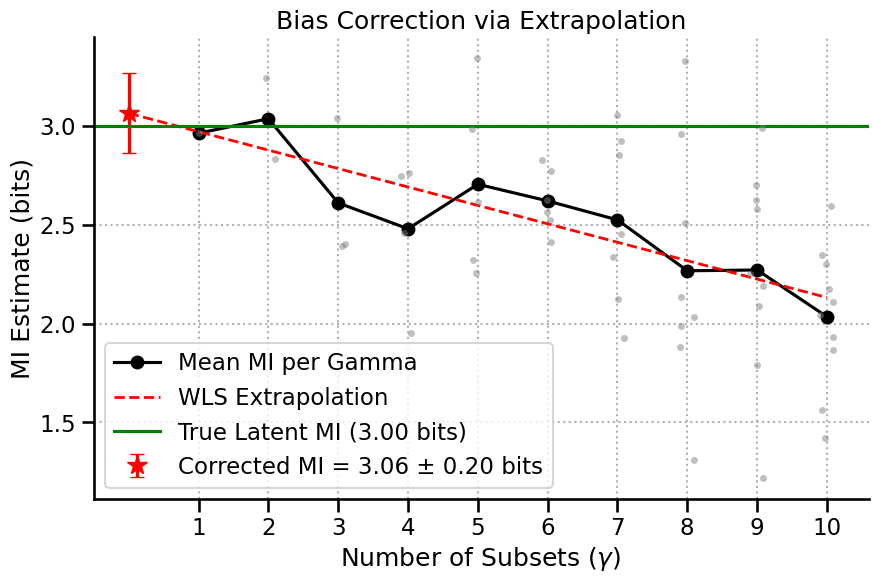

In [11]:
if rigorous_results and rigorous_results.dataframe is not None and not rigorous_results.dataframe.empty:
    ax = rigorous_results.plot(show=False)
    ax.axhline(y=latent_mi_bits, color='green', linestyle='-', label=f'True Latent MI ({latent_mi_bits:.2f} bits)')
    ax.legend()
    plt.show()
else:
    print("Could not generate plot because rigorous analysis failed or produced no valid data.")